In [1]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


# Part 1

Dataset contains 116414 files.
Randomly selected 5000 files for analysis...


100%|██████████| 5000/5000 [04:14<00:00, 19.63it/s]
/var/folders/qf/spzvkx2x32ggwn46dr3vw25m0000gn/T/ipykernel_1342/527318737.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/qf/spzvkx2x32ggwn46dr3vw25m0000gn/T/ipykernel_1342/527318737.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(



Identified 7 common Via sizes in the sample.
Plotting sizes: [10082, 15123, 20164, 25205, 30246, 35287, 40328]


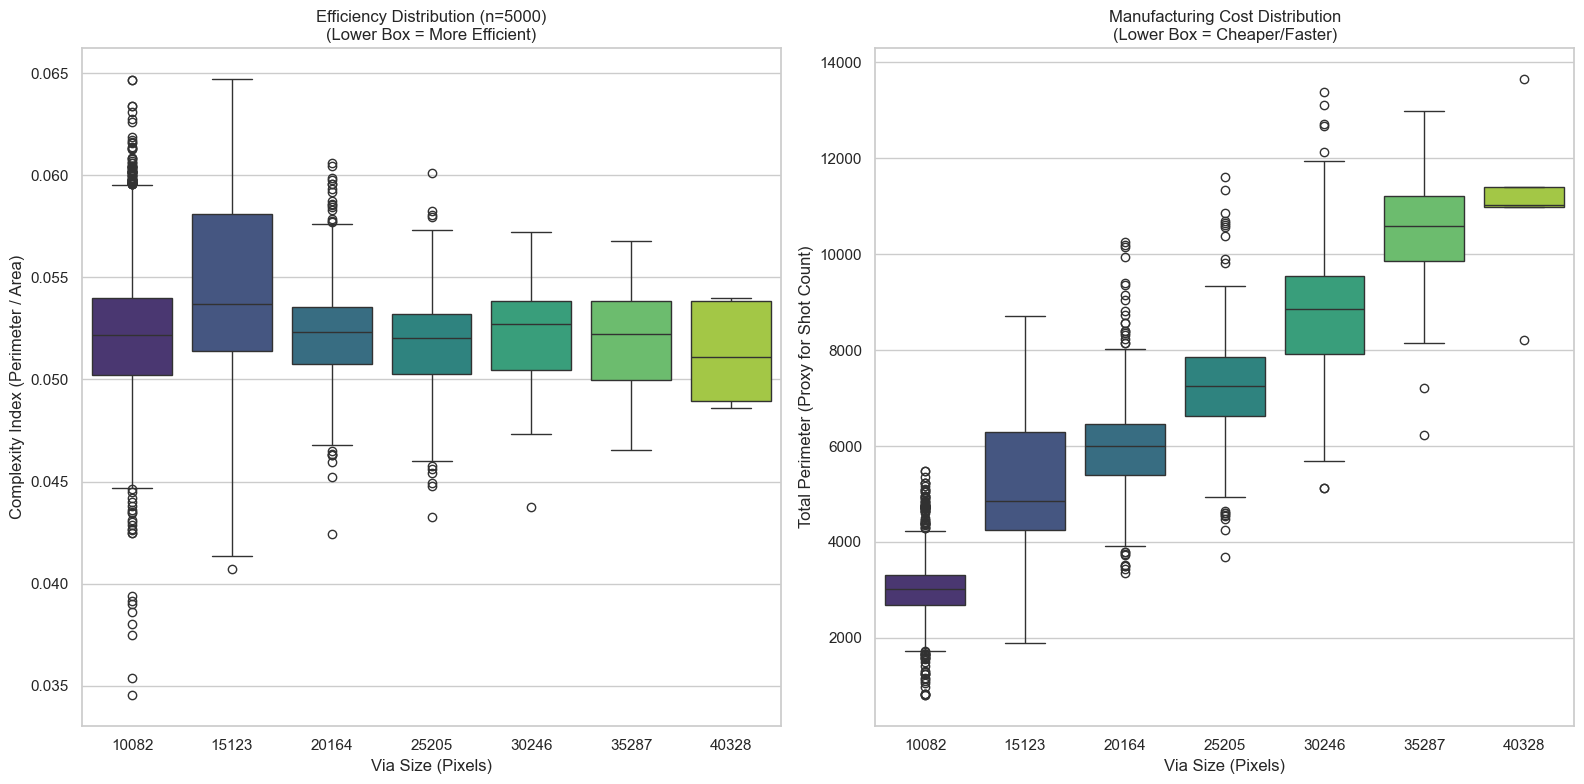

In [10]:
import os
import glob
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

def analyze_sampled_via_distribution():
    # --- CONFIGURATION ---
    BASE_PATH = "../Datasets/lithodata" 
    VIA_TARGET_PATH = os.path.join(BASE_PATH, "ViaSet", "target")
    VIA_MASK_PATH = os.path.join(BASE_PATH, "ViaSet", "pixelILT")
    
    SAMPLE_SIZE = 5000  # Number of random files to inspect
    MIN_GROUP_SIZE = 5  # Only plot sizes that appear at least 5 times in the sample
    
    # 1. Gather All Filenames (Fast)
    if not os.path.exists(VIA_TARGET_PATH):
        print("Error: Via Target path not found.")
        return

    all_files = glob.glob(os.path.join(VIA_TARGET_PATH, "*.png"))
    total_files = len(all_files)
    print(f"Dataset contains {total_files} files.")
    
    # 2. Random Sampling
    if total_files > SAMPLE_SIZE:
        sampled_files = random.sample(all_files, SAMPLE_SIZE)
        print(f"Randomly selected {SAMPLE_SIZE} files for analysis...")
    else:
        sampled_files = all_files
        print("Dataset smaller than sample size. Using all files.")
    
    data = []
    
    # 3. Processing Loop
    for t_path in tqdm(sampled_files):
        # Load Target
        target = cv2.imread(t_path, cv2.IMREAD_GRAYSCALE)
        if target is None: continue
        
        # Get Size (X-Axis)
        _, t_bin = cv2.threshold(target, 127, 255, 0)
        t_pixels = cv2.countNonZero(t_bin)
        
        if t_pixels == 0: continue
        
        # Load Mask
        filename = os.path.basename(t_path)
        m_path = os.path.join(VIA_MASK_PATH, filename)
        
        if not os.path.exists(m_path): continue
        
        mask = cv2.imread(m_path, cv2.IMREAD_GRAYSCALE)
        if mask is None: continue
        
        _, m_bin = cv2.threshold(mask, 127, 255, 0)
        
        # Get Metrics (Y-Axis)
        contours, _ = cv2.findContours(m_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        m_perimeter = 0
        m_area = 0
        for cnt in contours:
            m_perimeter += cv2.arcLength(cnt, True)
            m_area += cv2.contourArea(cnt)
            
        if m_area == 0: continue
        
        data.append({
            "Size": t_pixels,
            "Complexity": m_perimeter / m_area,
            "Cost": m_perimeter
        })

    # 4. Data Cleaning
    df = pd.DataFrame(data)
    
    if df.empty:
        print("No data collected.")
        return

    # Filter out rare outliers (sizes that appeared < MIN_GROUP_SIZE times)
    size_counts = df["Size"].value_counts()
    common_sizes = size_counts[size_counts >= MIN_GROUP_SIZE].index
    df_filtered = df[df["Size"].isin(common_sizes)]
    
    # Sort for plotting
    df_filtered = df_filtered.sort_values("Size")
    
    print(f"\nIdentified {len(common_sizes)} common Via sizes in the sample.")
    print(f"Plotting sizes: {sorted(common_sizes.tolist())}")

    # 5. Visualization
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # PLOT 1: EFFICIENCY (Complexity)
    sns.boxplot(
        data=df_filtered, 
        x="Size", 
        y="Complexity", 
        ax=axes[0], 
        palette="viridis"
    )
    axes[0].set_title(f"Efficiency Distribution (n={SAMPLE_SIZE})\n(Lower Box = More Efficient)")
    axes[0].set_ylabel("Complexity Index (Perimeter / Area)")
    axes[0].set_xlabel("Via Size (Pixels)")
    
    # PLOT 2: COST (Perimeter)
    sns.boxplot(
        data=df_filtered, 
        x="Size", 
        y="Cost", 
        ax=axes[1], 
        palette="viridis"
    )
    axes[1].set_title(f"Manufacturing Cost Distribution\n(Lower Box = Cheaper/Faster)")
    axes[1].set_ylabel("Total Perimeter (Proxy for Shot Count)")
    axes[1].set_xlabel("Via Size (Pixels)")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    analyze_sampled_via_distribution()

# Part 2

--- Processing 5000 samples... ---


100%|██████████| 5000/5000 [08:37<00:00,  9.66it/s]   


Data Collected. Groups found: <StringArray>
['3x Via', '2x Via', '5x Via', '4x Via']
Length: 4, dtype: str


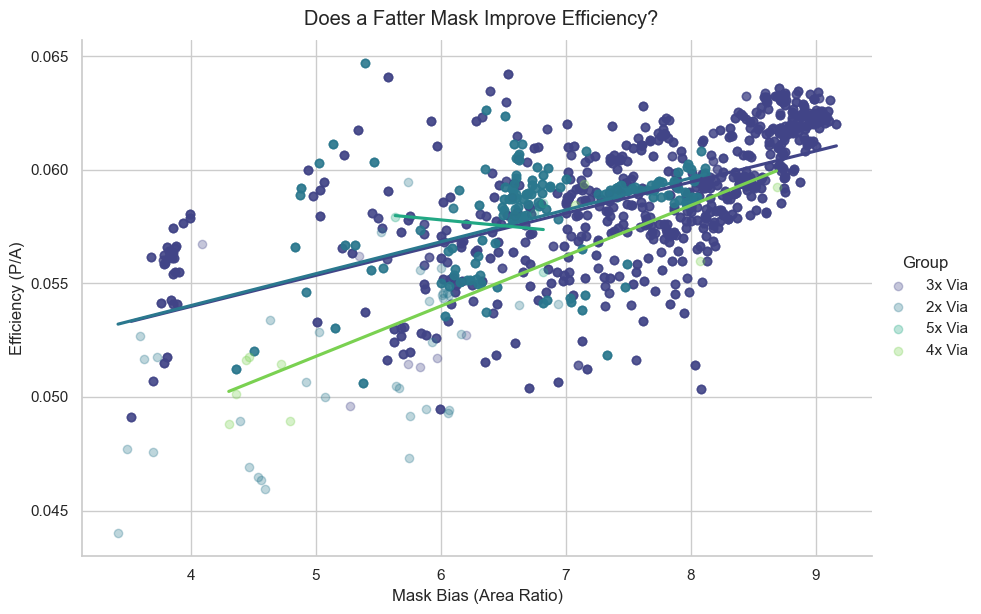

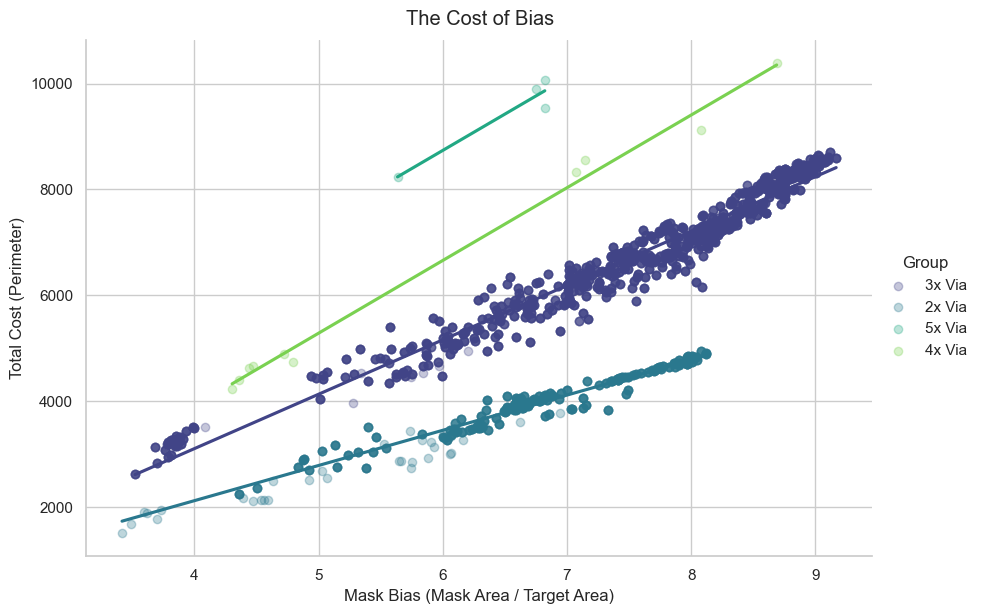

In [15]:
import os
import glob
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def analyze_bias_by_groups():
    # --- CONFIGURATION ---
    BASE_PATH = "../Datasets/lithodata" 
    VIA_TARGET_PATH = os.path.join(BASE_PATH, "ViaSet", "target")
    VIA_MASK_PATH = os.path.join(BASE_PATH, "ViaSet", "pixelILT")
    
    # "Lego Block" Logic
    UNIT_VIA_SIZE = 5041 
    TOLERANCE = 500 # Allow small variation around the block size
    
    # Limit to first 5000
    LIMIT = 5000
    
    data = []
    
    # 1. Get Files
    if not os.path.exists(VIA_TARGET_PATH):
        print("Error: Path not found.")
        return
        
    files = sorted(glob.glob(os.path.join(VIA_TARGET_PATH, "*.png")))[:LIMIT]
    print(f"--- Processing {len(files)} samples... ---")
    
    # 2. Processing Loop
    for t_path in tqdm(files):
        # Load Target
        target = cv2.imread(t_path, cv2.IMREAD_GRAYSCALE)
        if target is None: continue
        _, t_bin = cv2.threshold(target, 127, 255, 0)
        t_pixels = cv2.countNonZero(t_bin)
        
        if t_pixels == 0: continue
        
        # CATEGORIZE: Which "Lego Group" is this?
        # Round to nearest integer (e.g. 10080 -> 2.0)
        via_count_float = t_pixels / UNIT_VIA_SIZE
        via_count_int = int(round(via_count_float))
        
        # Filter: Is this a valid group? (Exclude noise/aliasing)
        expected_size = via_count_int * UNIT_VIA_SIZE
        if abs(t_pixels - expected_size) > TOLERANCE:
            continue
            
        # Only keep reasonable groups (1 to 5 vias) for readable plots
        if via_count_int < 1 or via_count_int > 5:
            continue
        
        # Load Mask
        filename = os.path.basename(t_path)
        m_path = os.path.join(VIA_MASK_PATH, filename)
        if not os.path.exists(m_path): continue
        
        mask = cv2.imread(m_path, cv2.IMREAD_GRAYSCALE)
        _, m_bin = cv2.threshold(mask, 127, 255, 0)
        
        # Metrics
        contours, _ = cv2.findContours(m_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        m_perimeter = 0
        m_area = 0
        for cnt in contours:
            m_perimeter += cv2.arcLength(cnt, True)
            m_area += cv2.contourArea(cnt)
            
        if m_area == 0: continue
        
        data.append({
            "Group": f"{via_count_int}x Via", # Categorical Label
            "Mask Bias (Area Ratio)": m_area / t_pixels,
            "Efficiency (P/A)": m_perimeter / m_area,
            "Cost (Perimeter)": m_perimeter
        })

    # 3. DataFrame
    df = pd.DataFrame(data)
    
    if df.empty:
        print("No valid data found.")
        return

    print(f"Data Collected. Groups found: {df['Group'].unique()}")


    # # ... (Step 3: DataFrame creation) ...
    # df = pd.DataFrame(data)

    # # --- START OUTLIER REMOVAL ---
    # def remove_outliers_iqr(df, column):
    #     Q1 = df[column].quantile(0.25)
    #     Q3 = df[column].quantile(0.75)
    #     IQR = Q3 - Q1
    #     lower_bound = Q1 - 1.5 * IQR
    #     upper_bound = Q3 + 1.5 * IQR
    #     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    # print(f"Original shape: {df.shape}")
    
    # # Filter both metrics
    # df = remove_outliers_iqr(df, "Efficiency (P/A)")
    # df = remove_outliers_iqr(df, "Cost (Perimeter)")
    
    # print(f"Shape after cleaning: {df.shape}")
    # # --- END OUTLIER REMOVAL ---

    # if df.empty:
    #     print("No valid data found after filtering.")
    #     return
    # # ... (Step 4: Visualization) ...


    # 4. Visualization
    sns.set_theme(style="whitegrid")
    
    # We use lmplot (Linear Model Plot) to automatically draw regression lines per group
    
    # # PLOT 1: Efficiency vs Bias
    # g1 = sns.lmplot(
    #     data=df,
    #     x="Mask Bias (Area Ratio)",
    #     y="Efficiency (P/A)",
    #     hue="Group",
    #     height=6,
    #     aspect=1.5,
    #     scatter_kws={'alpha': 0.3},
    #     palette="viridis"
    # )
    # g1.fig.suptitle("Does a Fatter Mask Improve Efficiency?", y=1.02)
    # g1.set_axis_labels("Mask Bias (Mask Area / Target Area)", "Efficiency (Lower is Better)")
    
    # # PLOT 2: Cost vs Bias
    # g2 = sns.lmplot(
    #     data=df,
    #     x="Mask Bias (Area Ratio)",
    #     y="Cost (Perimeter)",
    #     hue="Group",
    #     height=6,
    #     aspect=1.5,
    #     scatter_kws={'alpha': 0.3},
    #     palette="viridis"
    # )

        # PLOT 1: Efficiency vs Bias
    g1 = sns.lmplot(
        data=df,
        x="Mask Bias (Area Ratio)",
        y="Efficiency (P/A)",
        hue="Group",
        height=6,
        aspect=1.5,
        scatter_kws={'alpha': 0.3},
        palette="viridis",
        ci=None  # <--- THIS IS THE MAGIC FIX
    )
    g1.fig.suptitle("Does a Fatter Mask Improve Efficiency?", y=1.02)
    
    # PLOT 2: Cost vs Bias
    g2 = sns.lmplot(
        data=df,
        x="Mask Bias (Area Ratio)",
        y="Cost (Perimeter)",
        hue="Group",
        height=6,
        aspect=1.5,
        scatter_kws={'alpha': 0.3},
        palette="viridis",
        ci=None # <--- ADD HERE TOO
    )

    g2.fig.suptitle("The Cost of Bias", y=1.02)
    g2.set_axis_labels("Mask Bias (Mask Area / Target Area)", "Total Cost (Perimeter)")
    
    plt.show()

if __name__ == "__main__":
    analyze_bias_by_groups()